## Run bayesian inference

the notebook start by first loading the model config and checking the data, 

then you can run the sampling either in the HPC or in the notebook

In [1]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import numpy as np

from pl_temp_fit import (
    Exp_data_utils,
    config_utils,
    covariance_utils,
    generate_data_utils,
)

# access the right directory
os.chdir("/media/mohammed/Work/Work/pl_temp_fit")
#os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

In [2]:
# get test_ids in the database
path_database = Path("fit_experimental_emcee_pl/fit_data_base/")
model_config_files = list(path_database.glob("*.json"))
test_id_list = []
for id,model_config_file in enumerate(model_config_files):
    print(id,model_config_file)
    test_id = model_config_file.name.replace(".json","")
    test_id_list.append(test_id)
    model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = path_database)
    print(model_config_save["csv_name_pl"].split("/")[-1])


0 fit_experimental_emcee_pl/fit_data_base/17fd2bb8-fbb5-4491-9aee-9c46ec2e51ba.json
L8BO_mod_split0_split500.csv
1 fit_experimental_emcee_pl/fit_data_base/5c599fce-19c5-4992-be22-dbba129d4992.json
L8BO_mod_split0.0_split200.0.csv
2 fit_experimental_emcee_pl/fit_data_base/e7ed53f3-f1ef-46c2-9b98-35b366e9f04d.json
L8BO_mod_split200.0_split310.csv
3 fit_experimental_emcee_pl/fit_data_base/bf5fbc1d-c61f-4305-846b-82f7cf3eec97.json
IDTBR-DIB_mod_split200.0_split310.csv
4 fit_experimental_emcee_pl/fit_data_base/bd4ad569-9e40-4ada-8f28-7691488ff1ab.json
L8BO_mod_split0.0_split200.0.csv
5 fit_experimental_emcee_pl/fit_data_base/5689cb39-61a1-460c-b353-c11303f18d6d.json
IDTBR-DIB_mod_split0.0_split200.0.csv
6 fit_experimental_emcee_pl/fit_data_base/70f43164-60b1-493b-a3dd-894678a965a7.json
IDTBR-DIB_mod_split0_split500.csv
7 fit_experimental_emcee_pl/fit_data_base/2a3c2dce-53fc-4feb-b045-d6e236e83e03.json
L8BO_mod_split200.0_split310.csv
8 fit_experimental_emcee_pl/fit_data_base/cb37dae1-46f2-4

In [3]:
import importlib

importlib.reload(config_utils)
test_id = test_id_list[2]
model_config,model_config_save = config_utils.load_model_config(test_id, database_folder = path_database)
csv_name = model_config_save["csv_name_pl"]
print(model_config_save["csv_name_pl"].split("/")[-1])

L8BO_mod_split200.0_split310.csv


shape of mean value plot is (55, 2)


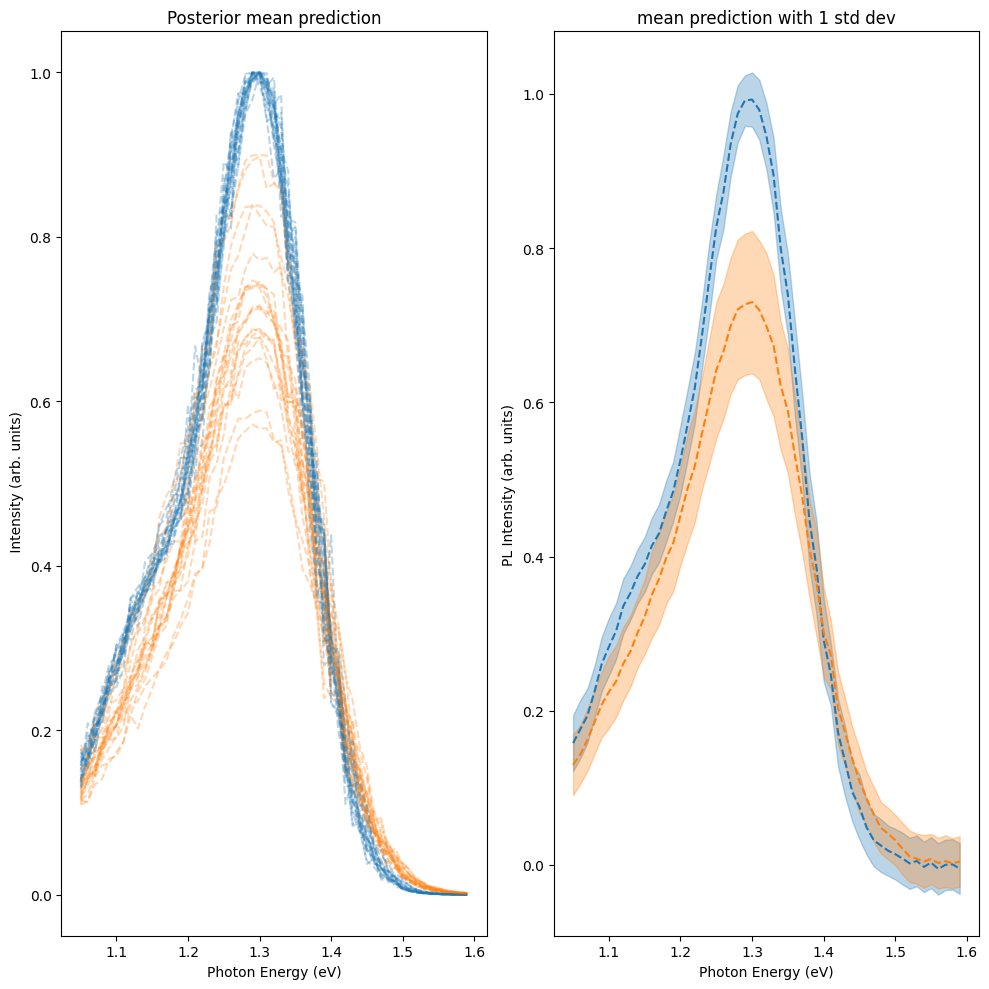

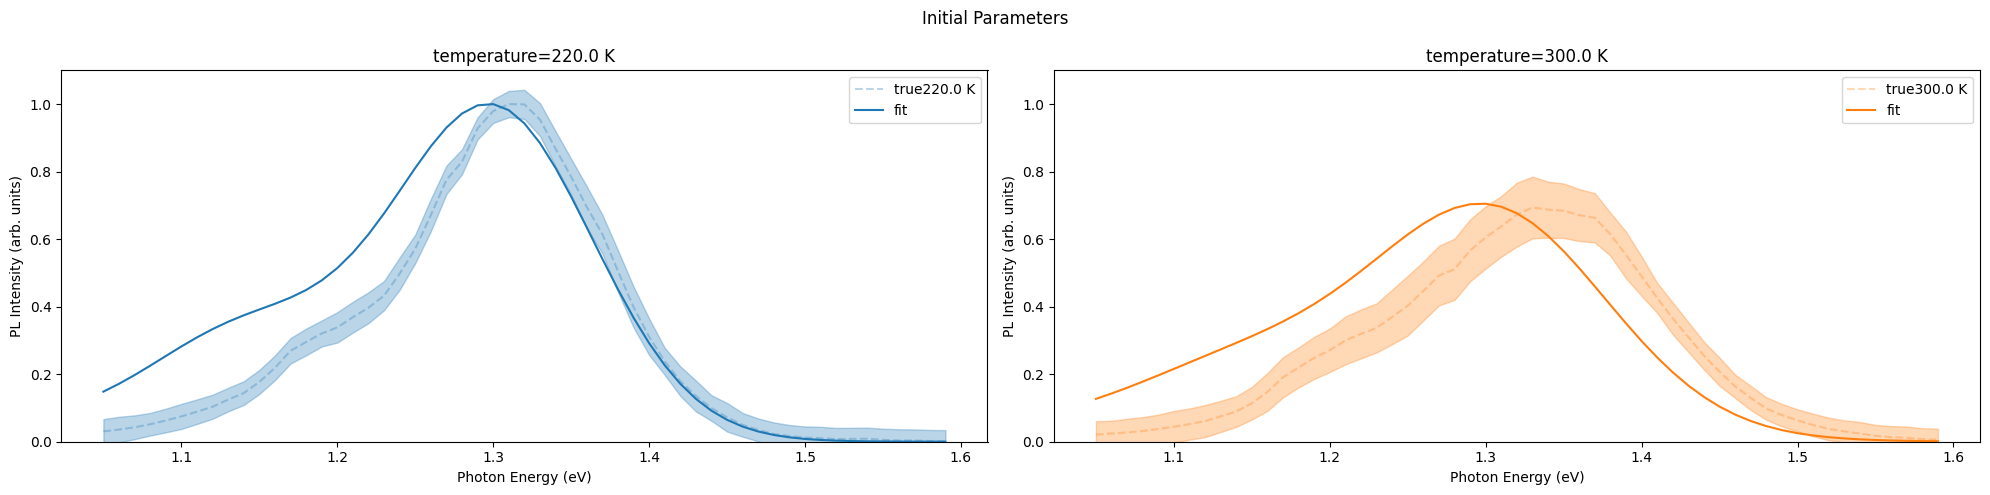

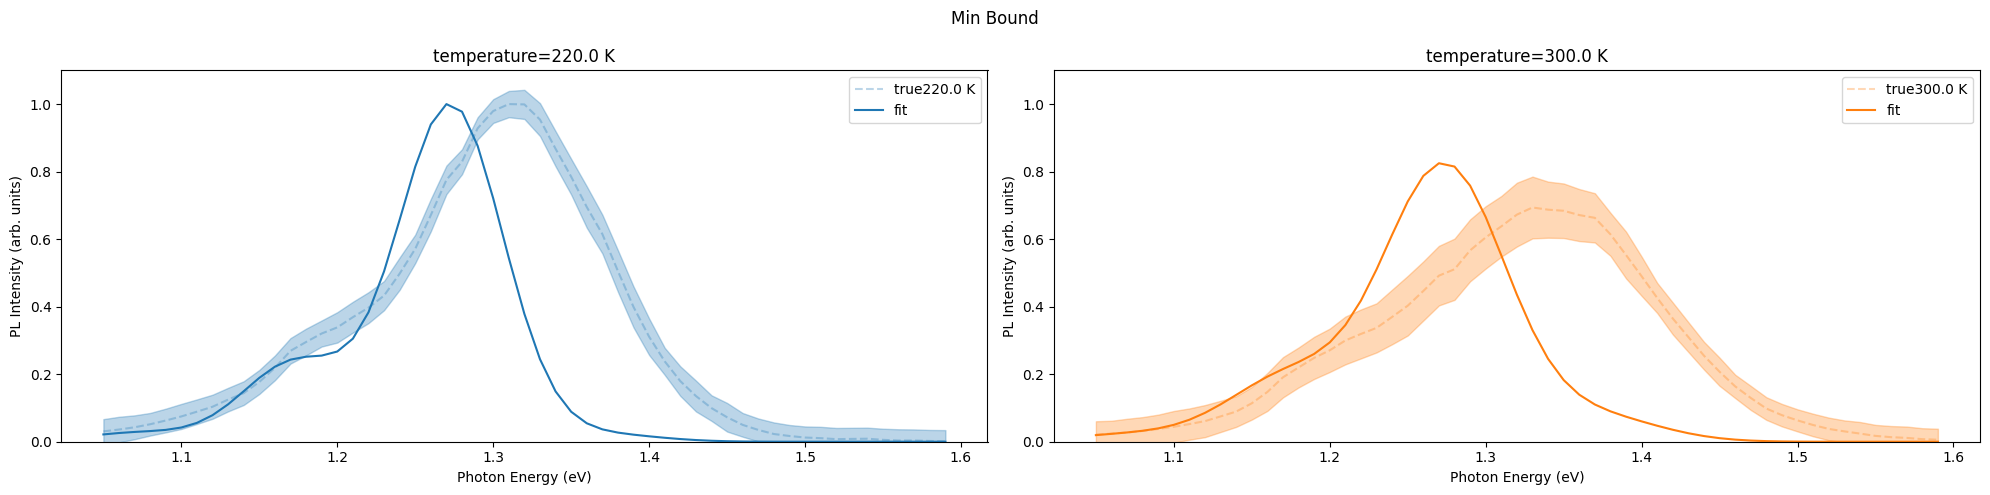

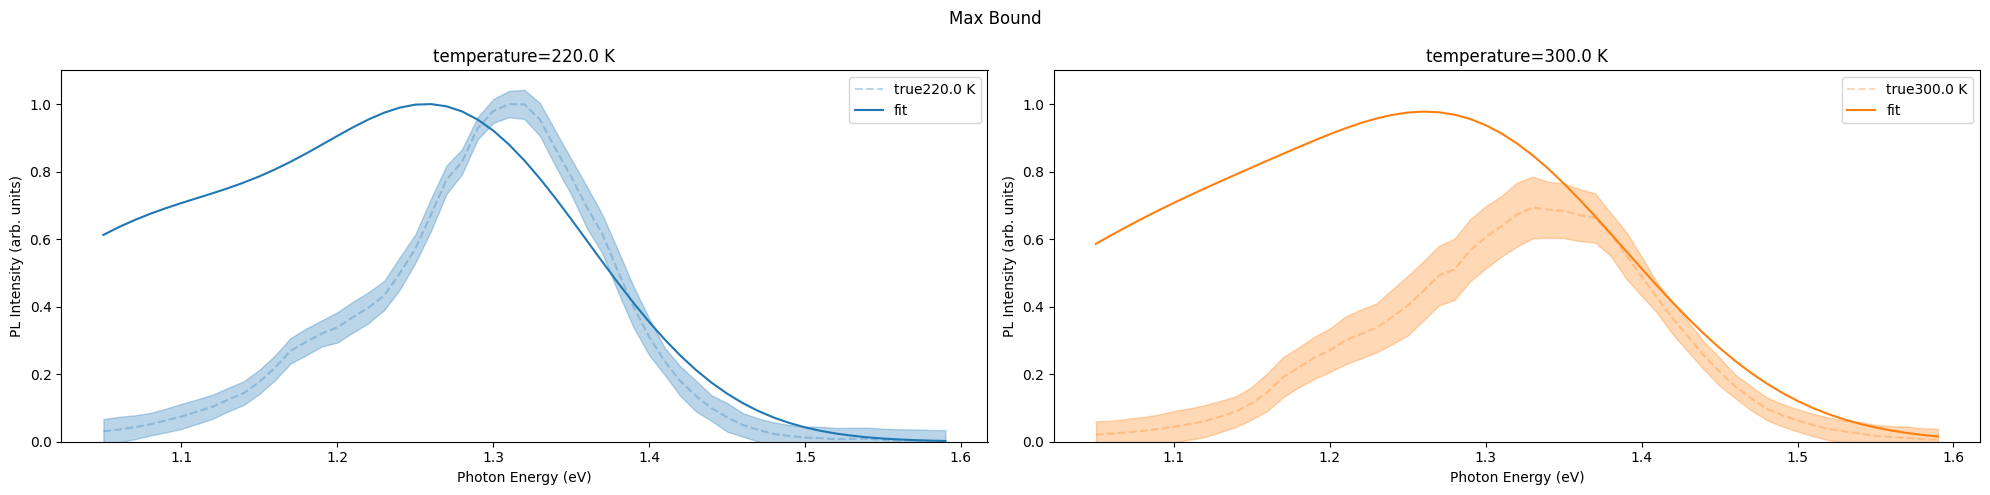

In [4]:
# plot the results with initial parameters
# and the maximum and minumum bounds
import importlib

from pl_temp_fit import fit_pl_utils

importlib.reload(fit_pl_utils)

fit_pl_utils.plot_fit_limits(model_config,model_config_save)


### run sampler in the notebook

In [5]:
import emcee

filename = model_config_save["save_folder"] + "/sampler.h5"
if os.path.exists(filename):
    try:
        reader = emcee.backends.HDFBackend(filename, name="multi_core")
        distribution = reader.get_chain(discard=0, flat=True)  
        true_parameters = fit_pl_utils.get_param_dict(model_config_save["params_to_fit_init"],distribution[-1])
    except AttributeError:
        print("no sampler found")
        true_parameters = model_config_save["params_to_fit_init"]
else:
    true_parameters = model_config_save["params_to_fit_init"]
    print("no sampler found")

shape of mean value plot is (55, 2)
Initial size: 0
(array([[-0.00460147]]), array([[8.76471055e-05]]), array([3.36990149e+08, 3.41419732e+08]), array([[1.24753290e+08, 1.78366065e+08]]))
[1.41480528 0.00766848 0.04881661 0.12385556 0.16308882]


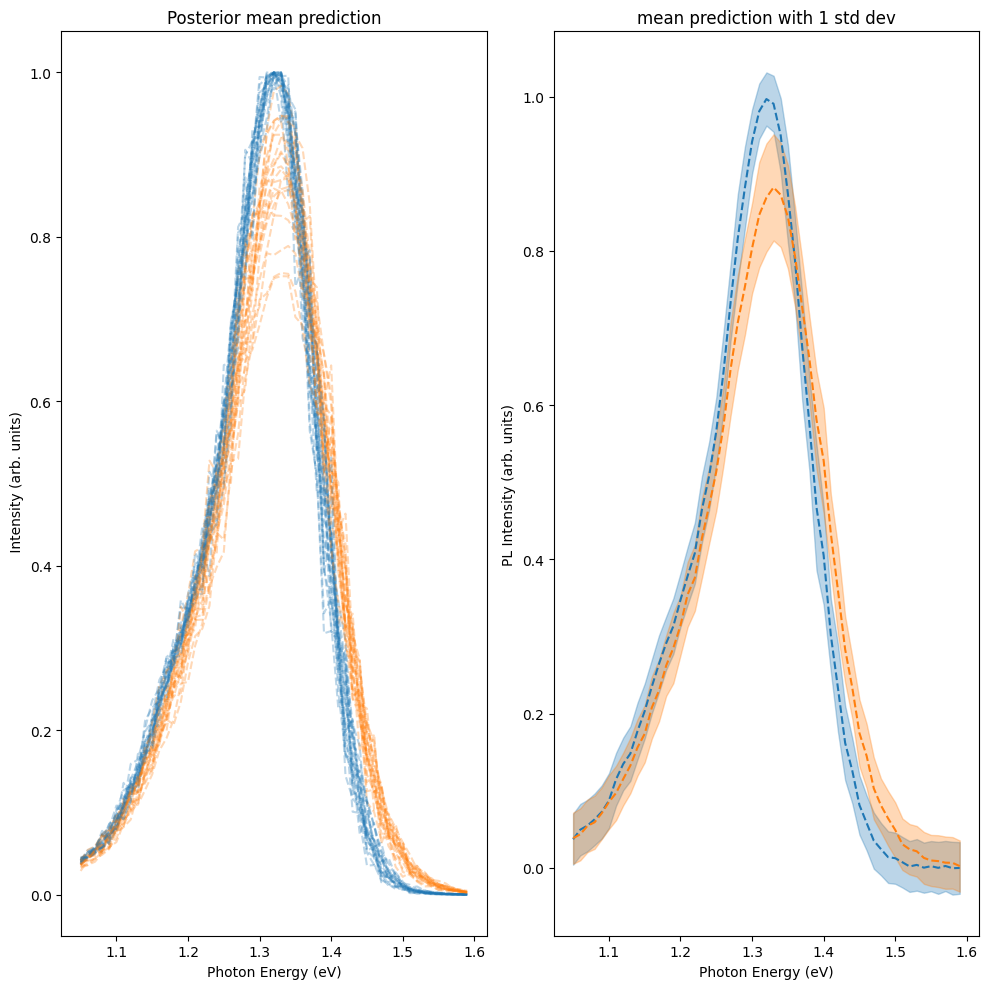

In [6]:
from multiprocess import Pool

importlib.reload(generate_data_utils)

import time


def pl_loglike(
    theta,
    data_pl,
    inv_covar_mat,
    temperature_list_pl,
    hws_pl,
    fixed_parameters_dict={},
    params_to_fit={},
):
    params_to_fit_updated = {"EX": {}, "CT": {}, "D": {}}
    counter = 0
    try:
        for key in ["EX", "CT", "D"]:
            if params_to_fit[key] == {}:
                continue
            for id, key2 in enumerate(params_to_fit[key].keys()):
                params_to_fit_updated[key][key2] = theta[counter]
                counter += 1
    except ValueError:
        print("The parameters to fit are not in the correct format")
    model_data_pl, EX_kr, Ex_knr = generate_data_utils.pl_trial(
        temperature_list_pl,
        hws_pl,
        fixed_parameters_dict,
        params_to_fit_updated,
    )
    model_data_pl = model_data_pl / np.max(model_data_pl.reshape(-1, 1))
    model_data_pl = model_data_pl.reshape(-1, 1)
    data_pl = data_pl / np.max(data_pl.reshape(-1, 1))
    data_pl = data_pl.reshape(-1, 1)
    
    diff_pl = data_pl - model_data_pl
    diff_pl[np.abs(data_pl) < 3e-2] = 0
    loglike = -0.5 * np.dot(
       diff_pl.T, np.dot(co_var_mat_pl, diff_pl)
    )
    Chi_squared = np.dot(
        diff_pl.T, np.dot(co_var_mat_pl, diff_pl)
    ) / (len(data_pl) - len(theta))
    return loglike, Chi_squared, EX_kr, Ex_knr

def run_sampler_parallel(
    save_folder,
    Exp_data_pl,
    co_var_mat_pl,
    params_to_fit,
    fixed_parameters_dict,
    min_bound,
    max_bound,
    model_config,
    nsteps=10000,
    coeff_spread=10,
    num_coords=32,
    num_processes=None,
    restart_sampling=True,
):

    init_params, min_bound_list, max_bound_list = [], [], []
    counter = 0
    for key in ["EX", "CT", "D"]:
        if params_to_fit[key] == {}:
            continue
        for key2 in params_to_fit[key].keys():
            init_params.append(params_to_fit[key][key2])
            min_bound_list.append(min_bound[key][key2])
            max_bound_list.append(max_bound[key][key2])
            counter += 1
    min_bound_list = np.array(min_bound_list)
    max_bound_list = np.array(max_bound_list)
    num_parameters = counter
    coords = init_params + 0.1 * coeff_spread * (
        max_bound_list - min_bound_list
    ) * np.random.randn(num_coords, num_parameters)
    nwalkers, ndim = coords.shape
    # Set up the backend
    # Don't forget to clear it in case the file already exists
    filename = save_folder + "/sampler.h5"
    # backend = hDFBackend_2(filename, name="multi_core")
    backend = emcee.backends.HDFBackend(filename, name="multi_core")
    if restart_sampling or os.path.isfile(filename) == False:
        backend.reset(nwalkers, ndim)
    else:
        reader = emcee.backends.HDFBackend(filename, name="multi_core")
        coords = reader.get_last_sample().coords
        # add a little noise to the initial position
        coords += 1e-3 * np.random.randn(*coords.shape)
    if coords.shape[0] != nwalkers:
        raise ValueError(
            f"invalid coordinate dimensions; expected {(nwalkers, ndim)}"
        )
    print(f"Initial size: {backend.iteration}")

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(nsteps)
    # This will be useful to testing convergence
    old_tau = np.inf

    # Here are the important lines
    if num_processes is None:
        import multiprocessing

        num_processes = multiprocessing.cpu_count()
        print(f"num_processes = {num_processes}")
    dtype = [
        ("log_likelihood", float),
        ("Chi square", float),
        ("Ex_knr", float),
        ("Ex_kr", float),
    ]
    inv_covar_mat = np.linalg.inv(co_var_mat_pl)
    def log_probability_pl_glob(theta):
        return pl_loglike(
            theta,
            Exp_data_pl,
            inv_covar_mat,
            model_config["temperature_list_pl"],
            model_config["hws_pl"],
            fixed_parameters_dict,
            params_to_fit,
        )


    return log_probability_pl_glob, coords
Temp_std_err = model_config_save["Temp_std_err"]
hws_std_err = model_config_save["hws_std_err"]
relative_intensity_std_error_pl = model_config_save["relative_intensity_std_error_pl"]
sigma = model_config_save["sigma"]
save_folder = model_config_save["save_folder"]
fixed_parameters_dict = model_config_save["fixed_parameters_dict"]

params_to_fit_init = model_config_save["params_to_fit_init"]
params_to_fit_init["EX"]["sigma"] = 0.01

min_bounds = model_config_save["min_bounds"]
max_bounds = model_config_save["max_bounds"]
csv_name = model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

co_var_mat_pl, variance_pl = (
    covariance_utils.plot_generated_data_pl(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
)
log_probability_pl_glob, coords = run_sampler_parallel(
    save_folder,
    Exp_data,
    co_var_mat_pl,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=3,
    coeff_spread=1,
    num_coords = 32,
    restart_sampling=True,
    num_processes=12,
)
print(log_probability_pl_glob(coords[0]))
print(coords[0])


In [7]:
import os

start = time.time()
with Pool(32) as pool:
    results = list(pool.map(log_probability_pl_glob, coords))
log_prob = np.array([float(l[0]) for l in results])
print(log_prob)
end = time.time()
print(f"multi process Time taken: {end-start}")


[-0.00460147 -0.00478949 -0.00498206 -0.00251065 -0.00599088 -0.00480287
 -0.00496453 -0.00550881 -0.0113313  -0.00992133 -0.00903354 -0.00333818
 -0.0053302  -0.00615068 -0.00370085 -0.00390514 -0.00631372 -0.00443019
 -0.00766731 -0.01151669 -0.00370037 -0.00375336 -0.00802276 -0.00697373
 -0.00405692 -0.003588   -0.00886359 -0.00198444 -0.00901704 -0.00591835
 -0.00518598 -0.00550894]
multi process Time taken: 0.420687198638916


/tmp/ipykernel_1300082/4157273268.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_prob = np.array([float(l[0]) for l in results])


In [8]:
start = time.time()
results = list(map(log_probability_pl_glob, coords))
log_prob = np.array([float(l[0]) for l in results])
print(log_prob)
end = time.time()
print(f"single process Time taken: {end-start}")


[-0.00460147 -0.00478949 -0.00498206 -0.00251065 -0.00599088 -0.00480287
 -0.00496453 -0.00550881 -0.0113313  -0.00992133 -0.00903354 -0.00333818
 -0.0053302  -0.00615068 -0.00370085 -0.00390514 -0.00631372 -0.00443019
 -0.00766731 -0.01151669 -0.00370037 -0.00375336 -0.00802276 -0.00697373
 -0.00405692 -0.003588   -0.00886359 -0.00198444 -0.00901704 -0.00591835
 -0.00518598 -0.00550894]
single process Time taken: 1.2722578048706055


/tmp/ipykernel_1300082/1817900979.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_prob = np.array([float(l[0]) for l in results])


shape of mean value plot is (55, 2)


  0%|          | 0/300 [00:00<?, ?it/s]/media/mohammed/Work/anaconda3/envs/pl_temp_fit/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 1/300 [00:00<01:38,  3.05it/s]/media/mohammed/Work/anaconda3/envs/pl_temp_fit/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 2/300 [00:00<01:36,  3.09it/s]/media/mohammed/Work/anaconda3/envs/pl_temp_fit/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 300/300 [01:17<00:00,  3.86it/s]

single process took 78.3 seconds


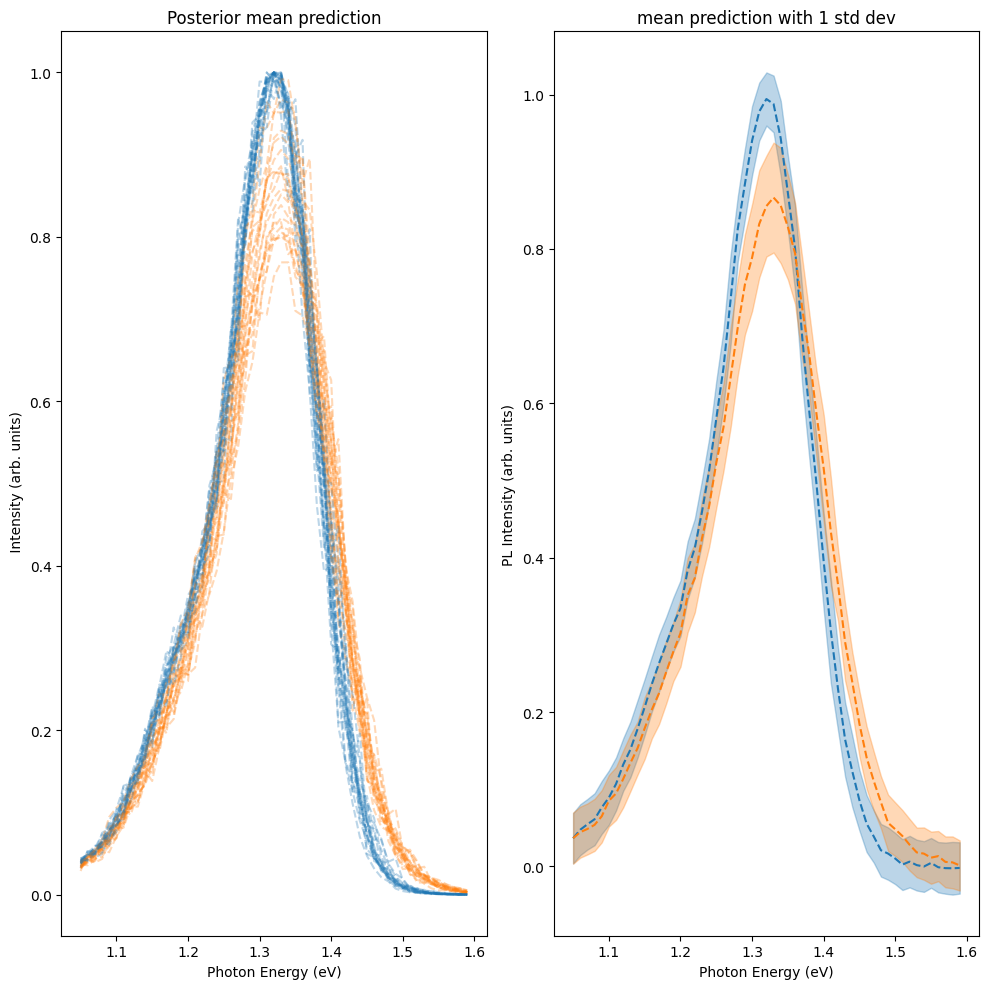

In [9]:
from pl_temp_fit import Emcee_utils, fit_pl_utils

importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_pl_utils)
importlib.reload(Emcee_utils)

Temp_std_err = model_config_save["Temp_std_err"]
hws_std_err = model_config_save["hws_std_err"]
relative_intensity_std_error_pl = model_config_save["relative_intensity_std_error_pl"]
sigma = model_config_save["sigma"]
save_folder = model_config_save["save_folder"]
fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
params_to_fit_init = model_config_save["params_to_fit_init"]
min_bounds = model_config_save["min_bounds"]
max_bounds = model_config_save["max_bounds"]
csv_name = model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

co_var_mat_pl, variance_pl = (
    covariance_utils.plot_generated_data_pl(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
)

fit_pl_utils.run_sampler_parallel(
    save_folder,
    Exp_data,
    co_var_mat_pl,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=300,
    coeff_spread=1,
    num_coords = 32,
    restart_sampling=False,
    num_processes=32,
)

shape of mean value plot is (55, 2)
no sampler found


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]

single process took 7.1 seconds


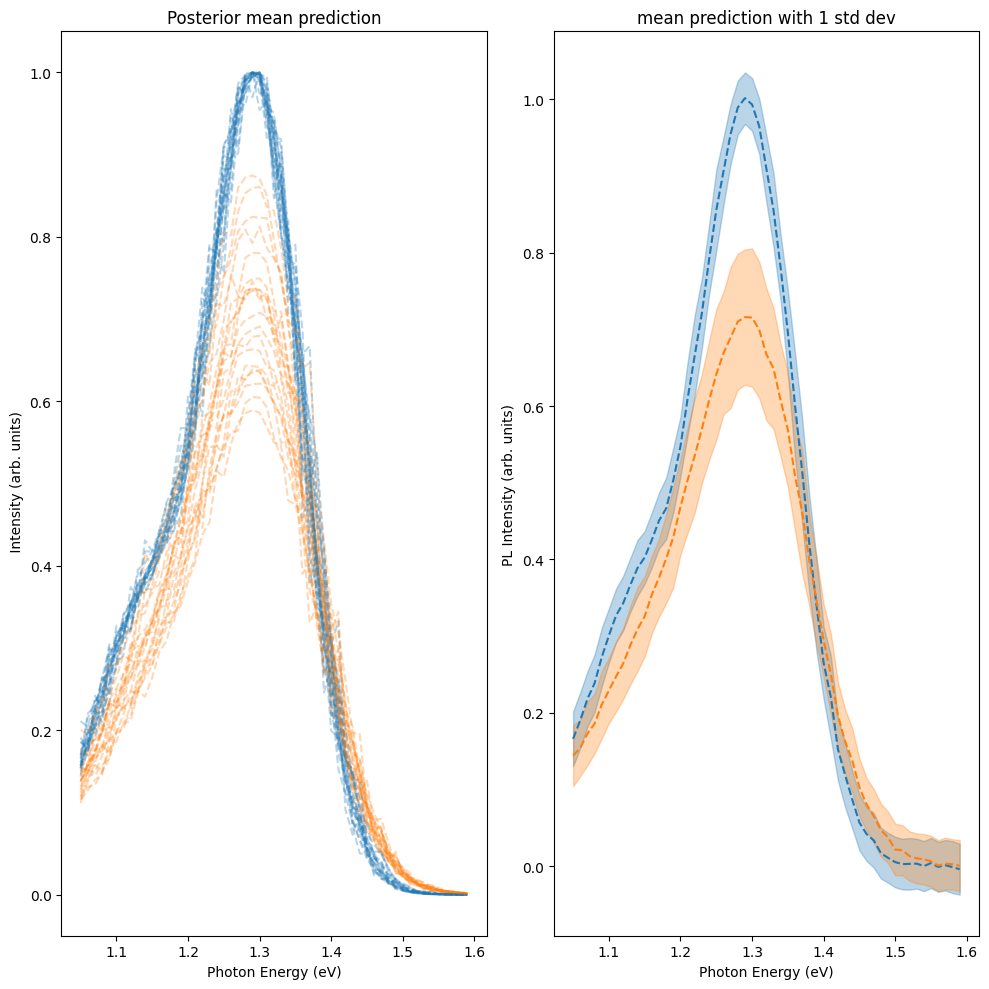

In [12]:
from pl_temp_fit import Emcee_utils, fit_pl_utils

importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_pl_utils)
importlib.reload(Emcee_utils)


Temp_std_err = model_config_save["Temp_std_err"]
hws_std_err = model_config_save["hws_std_err"]
relative_intensity_std_error_pl = model_config_save["relative_intensity_std_error_pl"]
sigma = model_config_save["sigma"]
save_folder = model_config_save["save_folder"]
fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
params_to_fit_init = model_config_save["params_to_fit_init"]
min_bounds = model_config_save["min_bounds"]
max_bounds = model_config_save["max_bounds"]
csv_name = model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

co_var_mat_pl, variance_pl = (
    covariance_utils.plot_generated_data_pl(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
)
filename = model_config_save["save_folder"] + "/sampler_single.h5"
if os.path.exists(filename):
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    distribution = reader.get_chain(discard=0, flat=True)  
    true_parameters = fit_pl_utils.get_param_dict(model_config_save["params_to_fit_init"],distribution[-1])
else:
    true_parameters = model_config_save["params_to_fit_init"]
    print("no sampler found")
save_folder = model_config_save["save_folder"] + "/single_core"
os.makedirs(save_folder, exist_ok=True)
fit_pl_utils.run_sampler_single(
    save_folder,
    Exp_data,
    co_var_mat_pl,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=5,
    coeff_spread=0.1,
    num_coords = 32,
    restart_sampling=False,
    #num_processes=32,
)

### run sampling in the HPC


In [13]:
model_config_id = test_id
csv_name = model_config_save["csv_name_pl"]
results_name = csv_name.replace(".csv","").split("/")[-1]
sh_name = f"Run_EMCEE_{results_name}.sh"
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=32:mem=80gb:avx=true \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pl_temp_fit     \n"+\
    f"python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id {model_config_id} \n"#${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
print(script) 
#with open(f'HPC_bash_script/{sh_name}', 'wb') as f:
#    f.write( bytes(script, 'utf-8'))  
script= f"qsub  -e ./cache -o ./cache HPC_bash_script/{sh_name}"#submit to HPC
#os.system(script)

#!/bin/bash 
#PBS -l walltime=07:59:01 
#PBS -l select=1:ncpus=32:mem=80gb:avx=true 
 
cd /rds/general/user/ma11115/home/pl_temp_fit/ 
module load anaconda3/personal 
source activate pl_temp_fit     
python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id e7ed53f3-f1ef-46c2-9b98-35b366e9f04d 



to run the scipt using the hpc you can just submit the job above

if you want ot run the job on the terminal you can run the script from the folder of pl_temp_fit using  for example

        python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id e7ed53f3-f1ef-46c2-9b98-35b366e9f04d 

where e7ed53f3-f1ef-46c2-9b98-35b366e9f04d  correspond to your model config id